## Econ 412 HW3 Question 1-5
### Juntao Li
### 906092273

In [1]:
# Set up
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings("ignore")

### 11.1

In [2]:
df = pd.read_excel("HPI.xls")
df.set_index("Date",inplace = True)
df.head()

,SD,LA
Date,,
1987-01-01,54.794112,59.426224
1987-02-01,55.215119,59.894861
1987-03-01,55.487803,60.401073
1987-04-01,56.049778,61.324334
1987-05-01,56.462099,62.030915


In [3]:
df['msa_sd'] = df['SD'].pct_change()*100
df['msa_la'] = df['LA'].pct_change()*100
df.dropna(inplace=True)
df.head()

,SD,LA,msa_sd,msa_la
Date,,,,
1987-02-01,55.215119,59.894861,0.768344,0.788602
1987-03-01,55.487803,60.401073,0.493859,0.845168
1987-04-01,56.049778,61.324334,1.012790,1.528550
1987-05-01,56.462099,62.030915,0.735632,1.152203
1987-06-01,56.787556,62.776564,0.576417,1.202060


In [4]:
# ADF Test
adf_test_sd = adfuller(df['msa_sd'])
adf_statistic_sd = adf_test_sd[0]
adf_pvalue_sd = adf_test_sd[1]
adf_critical_values_sd = adf_test_sd[4]

print('ADF Test for San Diego Home Price Growth:')
print(f'ADF Statistic: {adf_statistic_sd}')
print(f'p-value: {adf_pvalue_sd}')

ADF Test for San Diego Home Price Growth:
ADF Statistic: -3.7935843009657955
p-value: 0.0029736423063331115


In [5]:
adf_test_la = adfuller(df['msa_la'])
adf_statistic_la = adf_test_la[0]
adf_pvalue_la = adf_test_la[1]
adf_critical_values_la = adf_test_la[4]

print('ADF Test for Los Angeles Home Price Growth:')
print(f'ADF Statistic: {adf_statistic_la}')
print(f'p-value: {adf_pvalue_la}')
print('Critical Values:')
for key, value in adf_critical_values_la.items():
    print(f'   {key}: {value}')

ADF Test for Los Angeles Home Price Growth:
ADF Statistic: -3.7014499609427416
p-value: 0.004092805304511706
Critical Values:
   1%: -3.446205926287236
   5%: -2.8685297226414734
   10%: -2.570493298011322


Based on the ADF Tests, both time-series datasets are stationary. So we can build the VAR model.

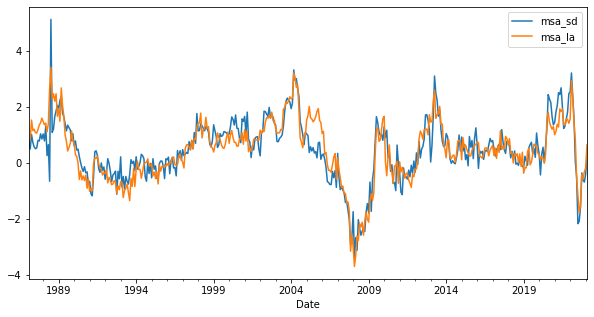

In [6]:
# Determine the optimal lag order
# Create a list of lag orders to test
max_lag = 15
lags = range(1, max_lag+1)

aic_values = []
bic_values = []
var_data = df[['msa_sd','msa_la']]

var_data.plot(figsize = (10,5))
plt.show()

In [7]:
# Estimate VAR models for different lag orders and calculate AIC and BIC
for lag in lags:
    model = VAR(var_data)  # 'data' is your input data
    results = model.fit(lag)
    aic_values.append(results.aic)
    bic_values.append(results.bic)

# Find the optimal order based on the minimum AIC and BIC values
optimal_order_aic = lags[aic_values.index(min(aic_values))]
optimal_order_bic = lags[bic_values.index(min(bic_values))]

# Print the optimal orders
print("Optimal lag order (AIC):", optimal_order_aic)
print("Optimal lag order (BIC):", optimal_order_bic)

Optimal lag order (AIC): 14
Optimal lag order (BIC): 2


From the results above, we can see that the optimal lag order for the VAR model based on the AIC is 14, while the optimal lag order based on the BIC is 2. The AIC and BIC are used to select the lag order that best balances between fit wellness and the complexity of the model.

For AIC and BIC, AIC tends to favor more complex models, while BIC penalizes model complexity more heavily. The choice between AIC and BIC depends on the trade-off we want to make between model fit and complexity. We should set the optimal lag as 2 in order to prevent overfitting in this case.

In [8]:
var_model = VAR(var_data,freq="MS").fit(maxlags = 10)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, May, 2023
Time:                     21:02:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.20153
Nobs:                     423.000    HQIC:                  -3.44460
Log likelihood:          -396.305    FPE:                  0.0272356
AIC:                     -3.60339    Det(Omega_mle):       0.0247202
--------------------------------------------------------------------
Results for equation msa_sd
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.045210         0.026145            1.729           0.084
L1.msa_sd          0.341873         0.056482            6.053           0.000
L1.msa_la          0.623888         0.071864            8.682          

In [9]:
print(var_model.test_whiteness(nlags=15))

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 15 is zero: reject at 5% significance level. Test statistic: 41.565, critical value: 31.410>, p-value: 0.003>


The Ljung-Box test has a p-value greater than 0.05, so it indicates that the residuals are white noise.
Therefore, the final model we have here is $$MSASD = 0.37MSASD_{t-1}+0.53MSASD_{t-2}+0.26MSALA_{t-1}-0.24MSALA_{t-2}$$

### 11.2

In [10]:
# Perform Granger causality test
max_lag = 2  # Maximum lag to consider in the test
granger_test_results = grangercausalitytests(var_data, max_lag, verbose=False)

# Interpret the results
for lag in range(1, max_lag + 1):
    p_value = granger_test_results[lag][0]['ssr_ftest'][1]
    if p_value < 0.05:
        print(f"Lag {lag}: Granger-causality is significant (p-value: {p_value})")
    else:
        print(f"Lag {lag}: Granger-causality is not significant (p-value: {p_value})")

Lag 1: Granger-causality is significant (p-value: 6.392571777426002e-18)
Lag 2: Granger-causality is significant (p-value: 2.1985904301132e-13)


We can see from the above Granger causality tests' p-values that they are all far below 0.05, which means there is significant eveidence that significant Granger-causality exists between the two series. These results suggest that the past values of Los Angeles Home Price Growth are useful in predicting values San Diego Home Price Growth at lag 1 and lag 2.

### 11.3

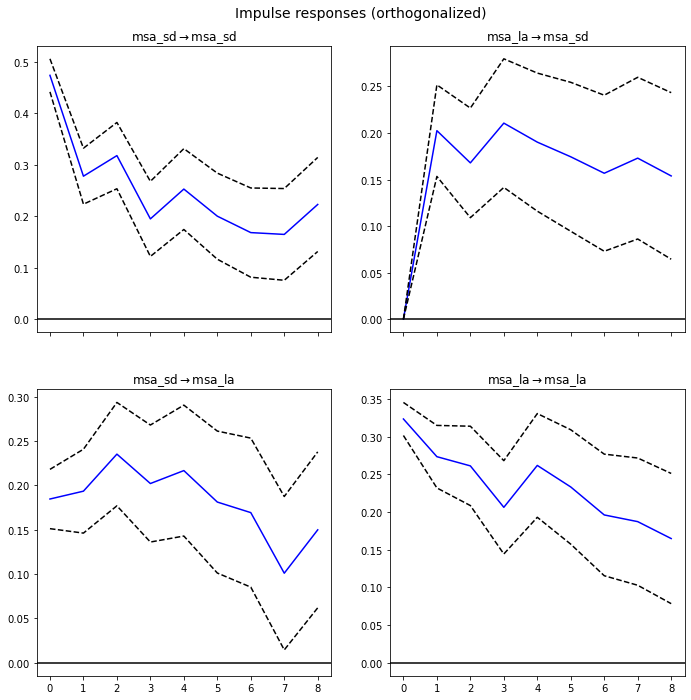

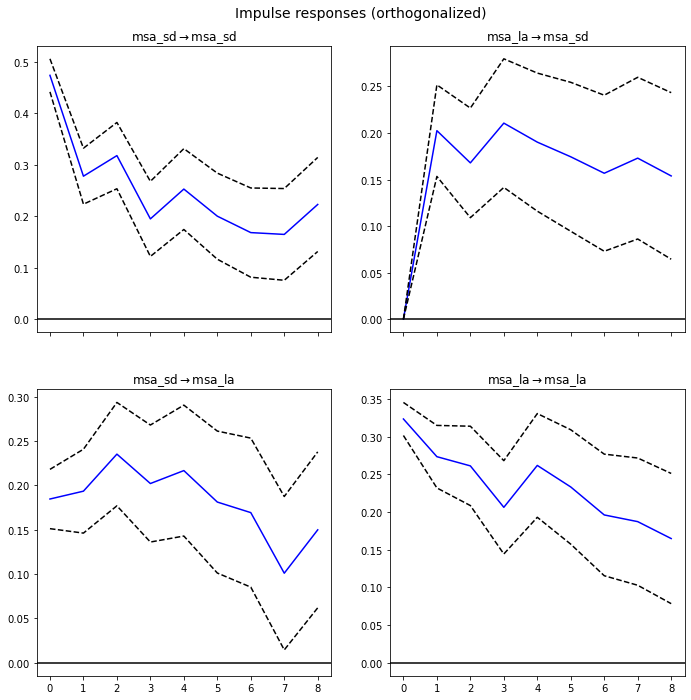

In [11]:
# Calculate impulse-response functions
irf = results.irf(periods=8) 

# Plot the impulse-response functions
irf.plot(orth=True)

The relationship between former home prices in Los Angeles and San Diego is currently showing a decreasing impact on each other. This observation aligns with the overall economic conditions of both Metropolitan Statistical Areas (MSAs). Historical price changes from a long time ago do not have a significant influence on the current price changes, while more recent price changes are likely to affect the current market dynamics.

In the context of analyzing this relationship using Vector Autoregression (VAR) models and impulse-response functions, the ordering of the variables becomes crucial. VAR models assume a causal relationship among the variables, and the ordering of the variables represents the assumed causal structure within the system. When examining the impulse-response functions, the model considers the effects of a shock in one variable on the subsequent behavior of the other variables.

Changing the ordering of the variables alters the underlying causal assumptions and, consequently, affects the interpretation of the impulse responses. Different orderings can lead to diverse outcomes in terms of the magnitude and timing of the impulse responses. Therefore, it is essential to carefully consider the ordering of variables in VAR models to obtain accurate and meaningful results that reflect the causal dynamics among the variables in question.

### 7.8

### (a)

In [12]:
df_retail=pd.read_excel('retail.xlsx')
df_retail['Date']= pd.to_datetime(df_retail['Date'])
df_retail.set_index('Date',inplace=True)
df_retail_all = df_retail['Turnover ;  New South Wales ;  Total (Industry) ;']
df_retail_all

Date
1982-04-01    1250.2
1982-05-01    1300.0
1982-06-01    1234.2
1982-07-01    1265.0
1982-08-01    1217.6
               ...  
2013-08-01    6675.2
2013-09-01    6604.1
2013-10-01    7026.9
2013-11-01    7391.1
2013-12-01    9185.3
Name: Turnover ;  New South Wales ;  Total (Industry) ;, Length: 381, dtype: float64

Text(0, 0.5, 'Sales')

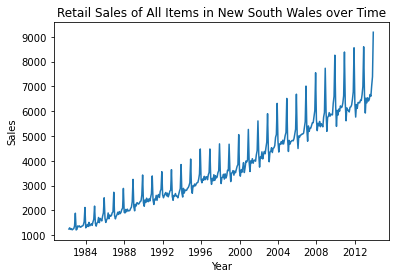

In [13]:
plt.plot(df_retail_all)
plt.title('Retail Sales of All Items in New South Wales over Time')
plt.xlabel('Year')
plt.ylabel('Sales')

From above plot, we can see that the magnitude of the seasonal pattern changes as the series evolves. Since the seasonal variation becomes larger as the year of the series increases, multiplicative seasonality can capture this relationship more accurately. Multiplicative seasonality allows for a proportional change in the seasonal effect as the series values change and it is necessary for this series.

### (b)

In [14]:
model_hw_undam = ExponentialSmoothing(df_retail_all, trend="mul", damped=False).fit()
model_hw_dam = ExponentialSmoothing(df_retail_all, trend="mul", damped=True).fit()

### (c)

In [15]:
# Split the data into training and testing sets
train_data_hw, test_data_hw = train_test_split(
    df_retail_all, test_size=0.2, shuffle=False)

In [16]:
model_hw_undam1 = ExponentialSmoothing(train_data_hw, trend="mul", damped=False).fit()
forecast_hw_undam1 = []

for i in range(len(test_data_hw)):
    # Make one-step ahead forecast
    forecast_value = model_hw_undam1.forecast(steps=1)[0]
    forecast_hw_undam1.append(forecast_value)
    
    # Update the model by incorporating the true value for evaluation
    true_value = test_data_hw[i]
    model_hw_undam1 = ExponentialSmoothing(np.append(train_data_hw, true_value), trend="mul", damped=False).fit()


mse = mean_squared_error(test_data_hw, forecast_hw_undam1)
rmse = np.sqrt(mse)

print("RMSE of undamped Holt-Winters Model:", rmse)

RMSE of undamped Holt-Winters Model: 1062.9658649802325


In [17]:
model_hw_dam1 = ExponentialSmoothing(train_data_hw, trend="mul", damped=True).fit()
forecast_hw_dam1 = []

for i in range(len(test_data_hw)):
    # Make one-step ahead forecast
    forecast_value = model_hw_dam1.forecast(steps=1)[0]
    forecast_hw_dam1.append(forecast_value)
    
    # Update the model by incorporating the true value for evaluation
    true_value = test_data_hw[i]
    model_hw_dam1 = ExponentialSmoothing(np.append(train_data_hw, true_value), trend="mul", damped=True).fit()


mse = mean_squared_error(test_data_hw, forecast_hw_dam1)
rmse = np.sqrt(mse)

print("RMSE of damped Holt-Winters Model:", rmse)

RMSE of damped Holt-Winters Model: 1091.0957690545638


Since the RMSE of undamped Holt-Winters model is smaller, I prefer undamped Holt-Winters model.

### (d)

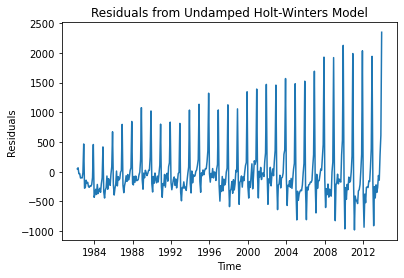

In [18]:
# Generate predictions for the data
predictions_hw_undam = model_hw_undam.fittedvalues

# Calculate the residuals
residuals_hw_undam = df_retail_all - predictions_hw_undam

# Plot the residuals
plt.plot(residuals_hw_undam)
plt.title("Residuals from Undamped Holt-Winters Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

In [19]:
# Perform the Ljung-Box test
lb_test_results = acorr_ljungbox(residuals_hw_undam, lags=[1, 5, 10])

ljung_p = np.mean(lb_test_results['lb_pvalue'])
ljung_p = round(ljung_p, 3)
print("Ljung Box (A), p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box (A), p value: 0.0 , Residuals are correlated


It seems that the magnitude of the residuals above is increasing as time passes by and there is significant structure of the residuals, indicating that the residuals do not resemble white noise.

### (e)

In [20]:
train_data_hw1 = df_retail_all[:'2010-12-01']
test_data_hw1 = df_retail_all['2011-01-01':]

In [21]:
##RMSE of undamped Holt-Winters Model

# Fit the Holt-Winters' model to the training data
model_hw_undam2 = ExponentialSmoothing(train_data_hw1, trend="mul", damped=False).fit()

# Generate forecasts for the testing data
forecast_hw_undam2 = model_hw_undam2.forecast(steps=len(test_data_hw1))

# Calculate RMSE
mse_hw_undam2 = mean_squared_error(test_data_hw1, forecast_hw_undam2)
rmse_hw_undam2 = np.sqrt(mse_hw_undam2)

In [22]:
##RMSE of the seasonal naïve approach

# Fit the seasonal naïve approach to the training data
model_hw_undam3 = ExponentialSmoothing(train_data_hw1, seasonal='add', seasonal_periods=12).fit()

# Generate forecasts for the testing data
forecast_hw_undam3 = model_hw_undam3.forecast(steps=len(test_data_hw1))

# Calculate RMSE
mse_hw_undam3 = mean_squared_error(test_data_hw1, forecast_hw_undam3)
rmse_hw_undam3 = np.sqrt(mse_hw_undam3)

In [23]:
print("RMSE of undamped Holt-Winters Model:", rmse_hw_undam2)
print("RMSE of the seasonal naïve approach:", rmse_hw_undam3)

RMSE of undamped Holt-Winters Model: 883.6073536876124
RMSE of the seasonal naïve approach: 329.47229594548116


Since the RMSE of the seasonal naïve approach is smaller, I cannot beat the seasonal naïve approach.

### 7.9

In [24]:
# Perform STL decomposition on the Box-Cox transformed series
transformed_train, lambda_value = stats.boxcox(train_data_hw1)
transformed_train = pd.Series(transformed_train, index=train_data_hw1.index)
decomposition = seasonal_decompose(transformed_train, model='multiplicative', extrapolate_trend='freq')

# Obtain the seasonally adjusted component from the decomposition
seasonally_adjusted = decomposition.resid

# Fit ETS model on the seasonally adjusted data
model_ets = ETSModel(seasonally_adjusted, error='add', trend='add',
                     damped_trend=False, seasonal='add', seasonal_periods=13).fit()

# Make forecasts on the test set
fc = model_ets.forecast(len(test_data_hw1))

# Inverse transform the forecasts using the Box-Cox transformation
inv_fc = inv_boxcox(fc, lambda_value)

# Calculate RMSE
mse_ets = mean_squared_error(test_data_hw1, inv_fc)
rmse_ets = np.sqrt(mse_ets)

print("RMSE of ETS Model:", rmse_ets)
print("RMSE of the seasonal naïve approach:", rmse_hw_undam3)

RMSE of ETS Model: 6623.328519183246
RMSE of the seasonal naïve approach: 329.47229594548116


The ETS model has much higher RMSE compared to the RMSE of the best previous forecast on the test set, so I think the previous model is still better.